In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV,           RepeatedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler,                                       MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor,                                                   GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from datetime import datetime
import xgboost as xgb

import seaborn as sns

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

#### Datasets

In [133]:
import os
for dirname, _, filenames in list(os.walk('./input/'))[1:2]:
    TRAIN_DATASET_PATH = os.path.join(dirname, filenames[3]).replace("\\","/")
    TEST_DATASET_PATH = os.path.join(dirname, filenames[2]).replace("\\","/")
    SUBMIT = os.path.join(dirname, filenames[1]).replace("\\","/")
        
TRAIN_DATASET_PATH, TEST_DATASET_PATH, SUBMIT 

('./input/real_estate_price_prediction_moscow/train.csv',
 './input/real_estate_price_prediction_moscow/test.csv',
 './input/real_estate_price_prediction_moscow/sample_submission.csv')

#### Auxiliary functions

In [134]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#### Loading Train and Test

In [135]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


#### Correlation

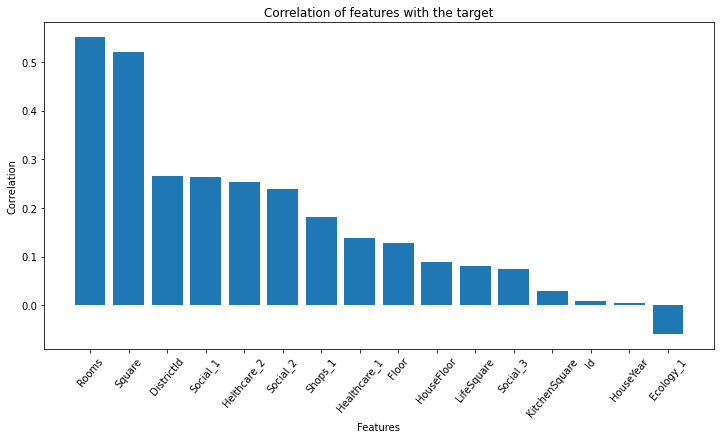

In [136]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(correlation.index, correlation)
plt.xticks(rotation=50)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.title('Correlation of features with the target')

plt.show()

#### Conditions

In [137]:
# CONDITIONS
        
## LifeSquare: NaN | > 200 | < 8
cLife = (train_df['LifeSquare'].isna()) | (train_df['LifeSquare'] < 6) | (train_df['LifeSquare'] > 200) # 200
        
## KitchenSquare: NaN | > 40 | < 3
cKitn = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] < 3) | (train_df['KitchenSquare'] > 40) # 60

## Square: NaN | > 300 | < 12 | < (LifeSquare + KitchenSquare + 3)
#(X['Square'] > 300) |
cSquare = (train_df['Square'].isna()) | (train_df['Square'] < 12) | \
(train_df.loc[~cLife & ~cKitn, 'Square'] < \
(train_df.loc[~cLife & ~cKitn, 'LifeSquare'] + train_df.loc[~cLife & ~cKitn, 'KitchenSquare'] + 3)) | (train_df['Square'] > 300)

In [138]:
# Rooms
train_df['_RoomsBug'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), '_RoomsBug'] = 1
        
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = 5

In [139]:
# Marks
## _SquareBug
train_df['_SquareBug'] = 0
train_df.loc[cSquare, '_SquareBug'] = 1

## _LifeSquareBug
train_df['_LifeSquareBug'] = 0
train_df.loc[cLife, '_LifeSquareBug'] = 1

## _KitchenSquareBug
train_df['_KitchenSquareBug'] = 0
train_df.loc[cKitn, '_KitchenSquareBug'] = 1

In [140]:
train_df[cLife | cKitn | cSquare].shape

(3707, 24)

In [141]:
# MEDIAN RATIOS by DistrictId
df = train_df[~cLife & ~cKitn & ~cSquare]

# Ratios: life/square & kitchen/square by DistrictIdf
df = df.groupby(['DistrictId', 'Rooms'])['LifeSquare', 'KitchenSquare', 'Square'].median()
df['_K_Life'] = df['LifeSquare'] / df['Square']
df['_K_Kitn'] = df['KitchenSquare'] / df['Square']

In [142]:
train_df = train_df.merge(df[['_K_Life', '_K_Kitn']], how='left', on=['DistrictId', 'Rooms'])
train_df.loc[train_df['_K_Life'].isna(), '_K_Life'] = train_df['_K_Life'].median()
train_df.loc[train_df['_K_Kitn'].isna(), '_K_Kitn'] = train_df['_K_Kitn'].median()

In [143]:
train_df[cLife | cKitn | cSquare]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,_RoomsBug,_SquareBug,_LifeSquareBug,_KitchenSquareBug,_K_Life,_K_Kitn
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000,0,0,1,0,0.596846,0.126053
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000,0,0,1,1,0.505260,0.219783
8,9951,1,1.0,46.887894,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.406250,0,0,0,1,0.505260,0.219783
9,8094,6,3.0,79.867477,75.085129,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.031250,0,0,0,1,0.572899,0.147592
18,4581,1,1.0,47.582481,NaN,1.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593750,0,0,1,1,0.505260,0.219783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9983,647,1,2.0,63.324024,NaN,1.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.328125,0,0,1,1,0.584301,0.156793
9987,11665,1,2.0,62.690056,64.602936,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.187500,0,1,0,0,0.584301,0.156793
9990,10635,21,1.0,18.983963,11.419796,2.0,1,5.0,1967,0.194489,B,B,47,8004,3,125.0,3,5,B,112411.218750,0,0,0,1,0.588459,0.165550
9991,11173,6,2.0,62.648777,NaN,0.0,6,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,182625.546875,0,0,1,1,0.570063,0.162194


In [144]:
# Square

# S = (Sk/Kk + Sl/Kl) / 2
train_df.loc[cSquare, 'Square'] = (\
train_df.loc[cSquare, 'KitchenSquare'] / train_df.loc[cSquare, '_K_Kitn'] + \
train_df.loc[cSquare, 'LifeSquare'] / train_df.loc[cSquare, '_K_Life']) / 2

In [148]:
# > 300 --> Square / 10
train_df.loc[train_df['Square'] > 300, 'Square'] = train_df.loc[train_df['Square'] > 300, 'Square'] / 10
# < 8 --> Square * 10
train_df.loc[train_df['Square'] < 8, 'Square'] = train_df.loc[train_df['Square'] < 8, 'Square'] * 10
# NaN --> Square.median()
train_df.loc[train_df['Square'].isna(), 'Square'] = train_df['Square'].median()

In [146]:
# KitchenSquare
train_df.loc[train_df['KitchenSquare'] > 40, 'KitchenSquare'] = train_df.loc[train_df['KitchenSquare'] > 40, 'KitchenSquare'] / 10
train_df.loc[cKitn, 'KitchenSquare'] = train_df.loc[cKitn, 'Square'] * train_df.loc[cKitn, '_K_Kitn']
train_df.loc[train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare']]


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,_RoomsBug,_SquareBug,_LifeSquareBug,_KitchenSquareBug,_K_Life,_K_Kitn
8,9951,1,1.0,46.887894,44.628132,10.305177,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.406250,0,0,0,1,0.505260,0.219783
9,8094,6,3.0,79.867477,75.085129,11.787823,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.031250,0,0,0,1,0.572899,0.147592
19,367,45,1.0,42.367290,40.012527,8.552258,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.984375,0,0,0,1,0.519352,0.201860
33,847,74,2.0,73.314972,74.131264,12.000896,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.375000,0,0,0,1,0.582534,0.163690
37,1699,9,1.0,78.936165,76.746651,15.392476,8,7.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,226206.968750,0,0,0,1,0.527553,0.194999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9954,2241,6,2.0,55.789898,52.956654,9.048794,14,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,172267.843750,0,0,0,1,0.570063,0.162194
9960,16258,48,3.0,96.056786,98.152802,10.025629,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.562500,0,0,0,1,0.628393,0.104372
9965,6441,52,3.0,85.796883,85.305244,10.775726,15,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B,204462.984375,0,0,0,1,0.594178,0.125596
9979,2201,6,1.0,40.043236,41.984322,8.716978,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.078125,0,0,0,1,0.497501,0.217689


In [147]:
# LifeSquare
## LS = S * K_LS
train_df.loc[cLife, 'LifeSquare'] = train_df.loc[cLife, 'Square'] * train_df.loc[cLife, '_K_Life']

## S < LS + KS --> LS = S * LSk - 4
condSquare = train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare']
train_df.loc[condSquare, 'LifeSquare'] = train_df.loc[condSquare, 'Square'] * train_df.loc[condSquare, '_K_Life'] - 4